# **Imports**

In [ ]:
# the working save load avoids us the pain of having to retrain. however, we'll still need to keep the class defns
# for the custom blocks EncoderBlock etc in the notebook to be able to load the model

In [53]:
# Common
import os
import cv2 as cv
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np 

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
# from tensorflow.keras.utils import img_to_array, load_img

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [55]:
import tensorflow.keras as keras

In [56]:
os.listdir('waterBodiesDataset')

['Masks', 'Images']

# **Data**

In [57]:
images = []
mask = []

# image_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/'
# mask_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/'

image_path = './waterBodiesDataset/Images/'
mask_path = './waterBodiesDataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
    print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


## I ADDED THIS TO MAKE TRAINING FASTER; REMOVE FOR FINAL

In [96]:
# Also, other than using more images than 100 (artificia limit set by me), should we resize
# them to a bigger size than SIZE=128?
# At the end, will also need to modify the epochs and stuff,
# the attn UNet is running for fewer ones etc.
# Also added some decorates for testing the custom layer save thing

# https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers

"""
Now that saving and loading is working here, try
to get it to work in a seperate notebok.
I think I'll need the EncoderBlock and DecoderBlock classes in another notebook
to define the custom shit but then it should be able to load!
"""

In [59]:

image_names = image_names[:50]
mask_names = mask_names[:50]

In [60]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = img_to_array(load_img(path)).astype('float')/255.
    img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = img_to_array(load_img(path)).astype('float')/255.
    mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
    masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 50/50 [00:00<00:00, 139.80it/s]


In [61]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None: plt.title(title)
    plt.axis('off')

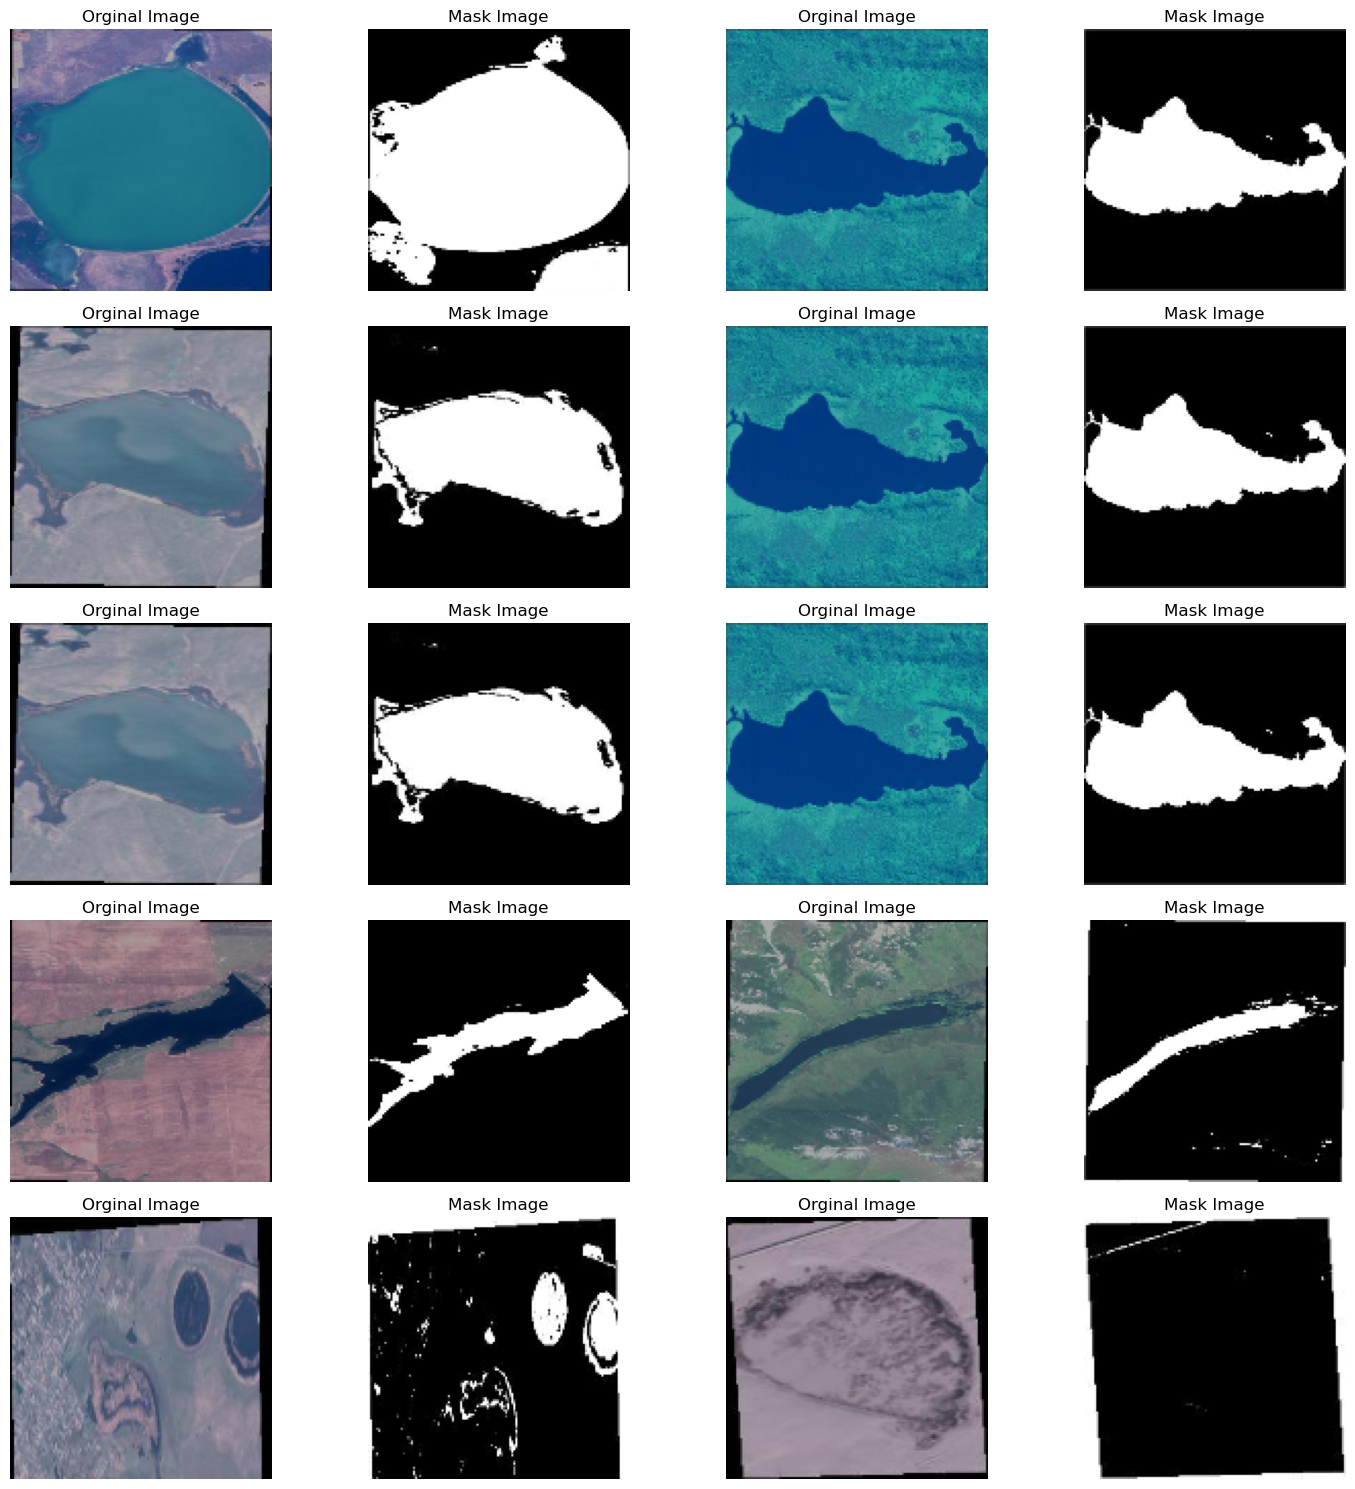

In [62]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        show_image(images[id], title="Orginal Image")
    elif i%2==0:
        show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')
plt.tight_layout()
plt.show()

# **U-Net**

In [81]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [82]:
# Contraction 
# @tf.keras.utils.register_keras_serializable()
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        if self.pooling: 
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

# Expansion
# @tf.keras.utils.register_keras_serializable()
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.net(c_)
        return x
 

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate
        }

# Callback 
class ShowProgress(keras.callbacks.Callback):
    def __init__(self, SIZE):
        self.SIZE = SIZE
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = self.model.predict(real_img)[0]
        mask = masks[id]

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        show_image(real_img[0], title="Orginal Image")

        plt.subplot(1,3,2)
        show_image(pred_mask, title="Predicted Mask", cmap='gray')

        plt.subplot(1,3,3)
        show_image(mask, title="Orginal Mask", cmap='gray')


        plt.tight_layout()
        plt.show()

Epoch 1/20
2/2 [==============================] - 4s 830ms/step - loss: 0.7251 - accuracy: 0.2928 - IoU: 0.3557 - val_loss: 0.7462 - val_accuracy: 0.3148 - val_IoU: 0.2931


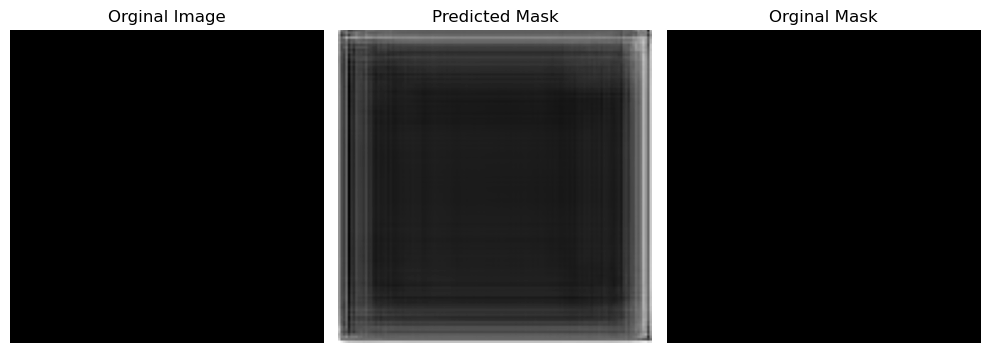

Epoch 2/20
2/2 [==============================] - 3s 703ms/step - loss: 0.6584 - accuracy: 0.5162 - IoU: 0.3557 - val_loss: 0.7948 - val_accuracy: 0.3168 - val_IoU: 0.2931


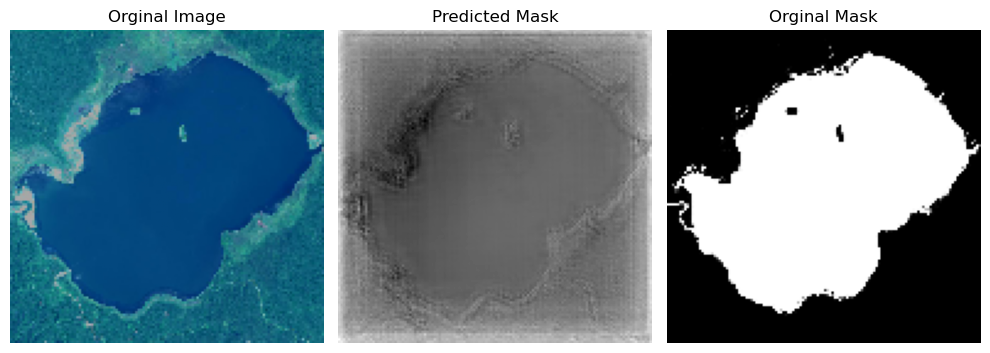

Epoch 3/20
2/2 [==============================] - 3s 605ms/step - loss: 0.6412 - accuracy: 0.5179 - IoU: 0.3557 - val_loss: 1.0993 - val_accuracy: 0.3171 - val_IoU: 0.2931


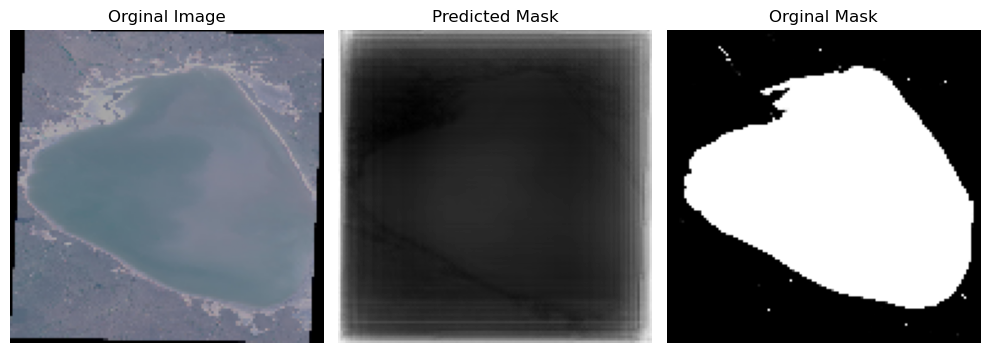

Epoch 4/20
2/2 [==============================] - 3s 591ms/step - loss: 0.6866 - accuracy: 0.5180 - IoU: 0.3557 - val_loss: 0.7328 - val_accuracy: 0.3166 - val_IoU: 0.2931


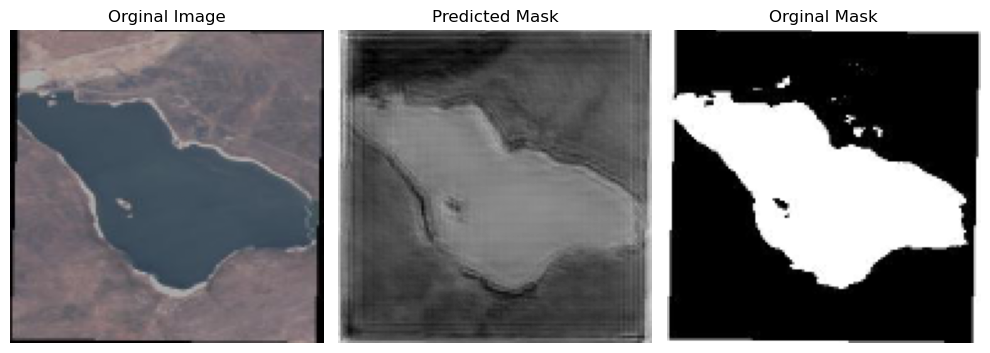

Epoch 5/20
2/2 [==============================] - 3s 592ms/step - loss: 0.6340 - accuracy: 0.5192 - IoU: 0.3557 - val_loss: 0.7587 - val_accuracy: 0.3179 - val_IoU: 0.2931


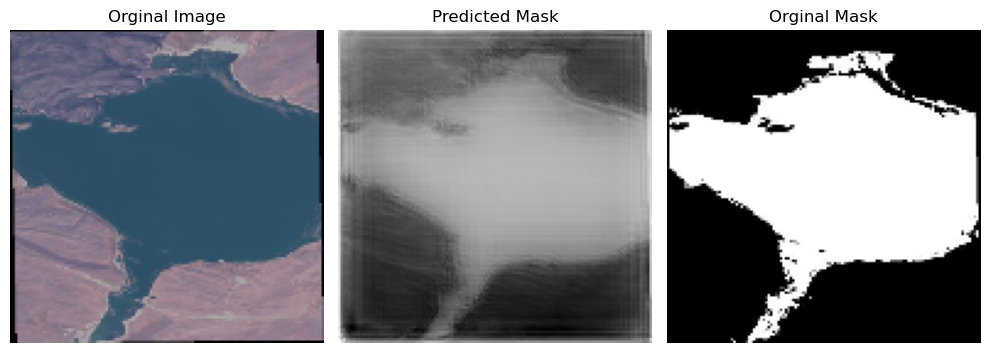

Epoch 6/20
2/2 [==============================] - 3s 616ms/step - loss: 0.6053 - accuracy: 0.5192 - IoU: 0.3557 - val_loss: 1.1827 - val_accuracy: 0.3193 - val_IoU: 0.2931


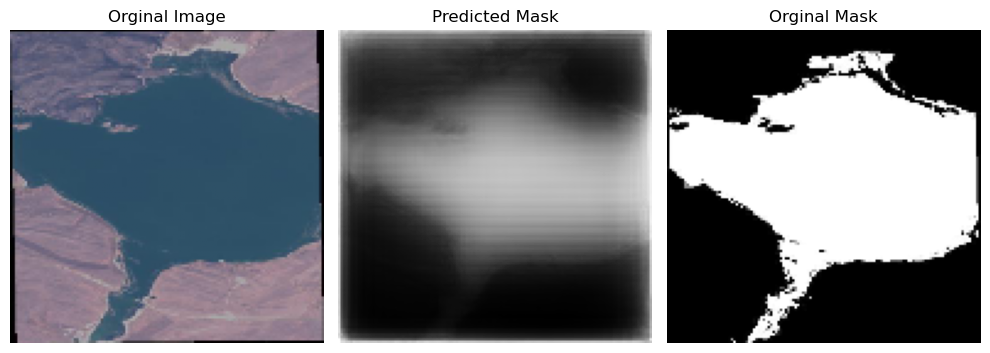

Epoch 7/20
2/2 [==============================] - 3s 605ms/step - loss: 0.6228 - accuracy: 0.5189 - IoU: 0.3557 - val_loss: 0.7548 - val_accuracy: 0.3183 - val_IoU: 0.2931


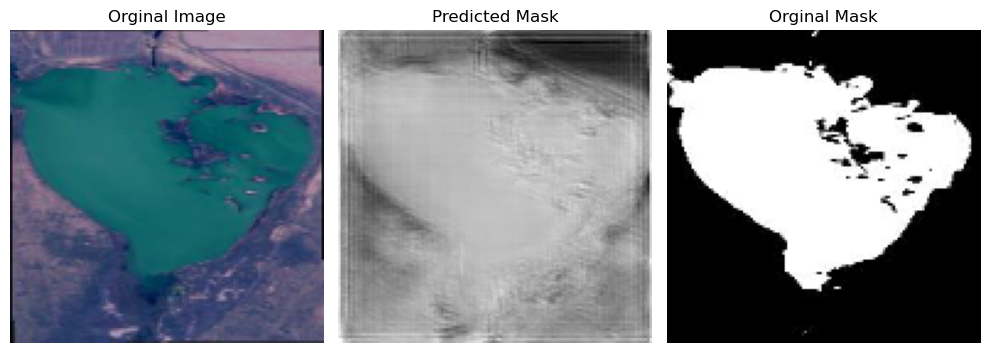

In [83]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1,c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

# Model
unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

# Compiling
unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("UNet.h5", save_best_only=True),
    ShowProgress( SIZE=SIZE)
]

# Training
unet_history = unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

**UNet Worked fast** but we can improve the performance using **Attention gate**.

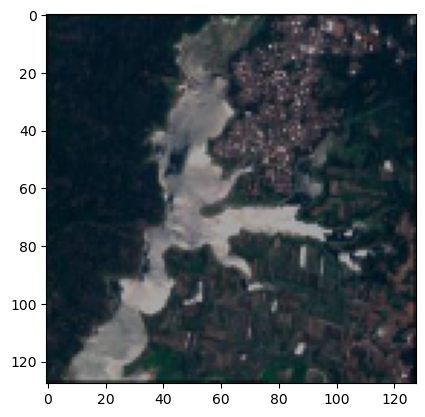

In [84]:
plt.imshow(X[1])

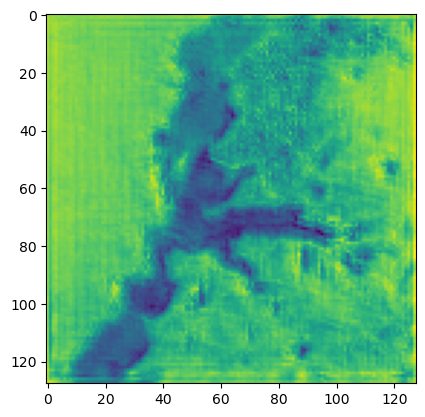

In [85]:
# new_model = tf.keras.models.load_model('./UNet.h5', custom_objects={'EncoderBlock': EncoderBlock})

# Check its architecture
# new_model.summary()

# unet_history.save_model(unet_history, 'UNet.h5')

plt.imshow(X[1])
temp = unet.predict(X[:2])
plt.imshow(temp[1])

In [86]:
tf.keras.models.save_model(unet, 'UNet.h5')

In [88]:
new_model = tf.keras.models.load_model('UNet.h5', custom_objects={
    'EncoderBlock':EncoderBlock, 'DecoderBlock':DecoderBlock
})

In [90]:
temp2 = new_model.predict(test_X[:1])

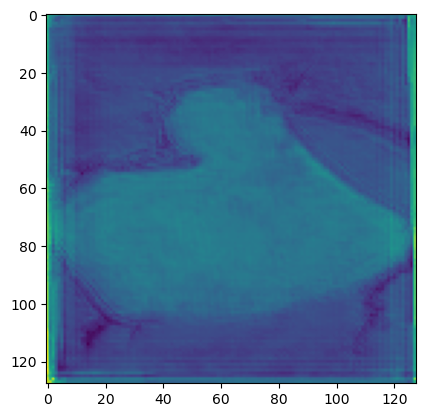

In [92]:
plt.imshow(temp2[0])

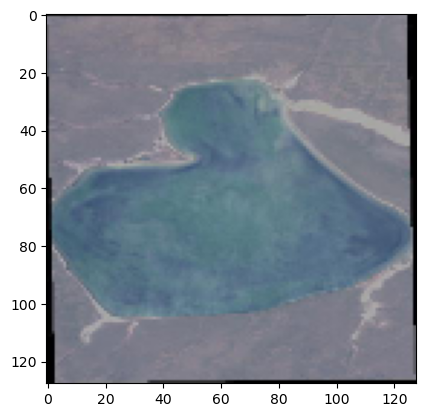

In [94]:
plt.imshow(test_X[0])

In [97]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 355.5 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 157.6 kB/s eta 0:00:001m149.2 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 kB 134.0 kB/s eta 0:00:001m133.2 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 7.7/16.2 MB 194.7 kB/s eta 0:00:44^C
     ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 7.7/16.2 MB 195.0 kB/s eta 0:00:44
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


# **Attention UNet**

The base Model structure of UNet is not changed by a **Short Attention Module** is inserted in the **Skip Connections** $:$

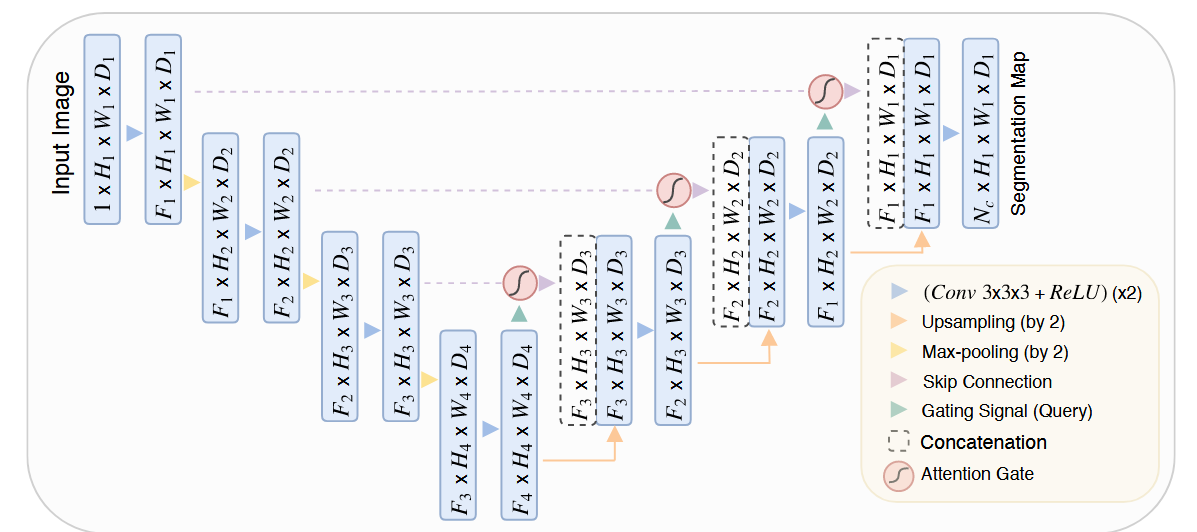

This added **Attention Module/Gate** has the **Following Architecture** $:$

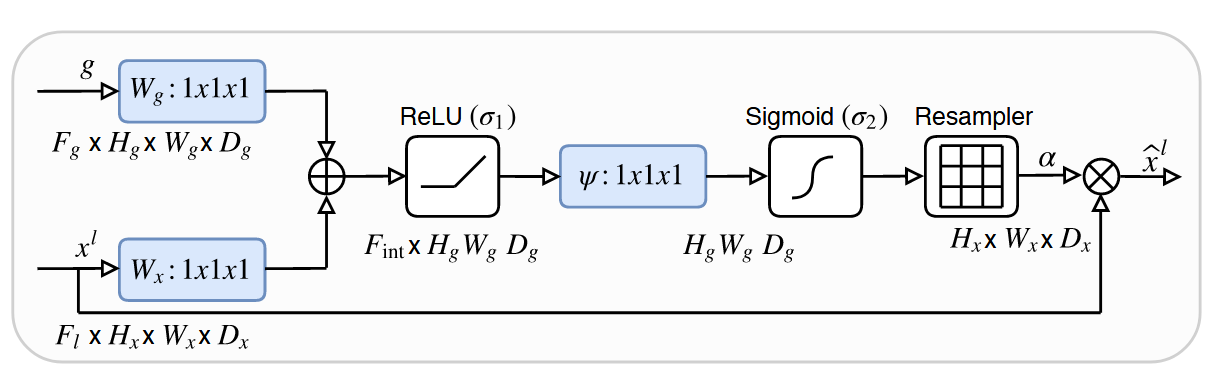

Where,
* $x$ are the **Skip Inputs**
* $g$ is the Input from **Previous Decoder**



This is a **Soft Attention Module** and it is self-explanatory for code look below :

---
$Bonus :$ [ViT](https://www.kaggle.com/code/utkarshsaxenadn/vit-vision-transformer-in-keras-tensorflow) is an example of a Hard Attention Model.

In [14]:
# Expansion
@tf.keras.utils.register_keras_serializable()
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.c1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')

    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.c1(c_)
        y = self.c2(x)
        return y

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
        }

In [50]:
@tf.keras.utils.register_keras_serializable()
class AttentionChannel(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionChannel, self).__init__(**kwargs)
        self.filters = filters
        
        self.C1 = Conv2D(filters, kernel_size=1, strides=1, padding='same', activation=None)
        self.C2 = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation=None)
#         self.relu = keras.activations.ReLU()
        tf.keras.layers.Activation('relu')

        self.add = keras.layers.Add()
        self.C3 = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')
        self.up = keras.layers.UpSampling2D()
        self.mul = keras.layers.Multiply()
        self.BN = BatchNormalization()
                
    def call(self, X):
        org_x, skip_g = X
        g = self.C1(org_x)
        x = self.C2(skip_g)
        x = self.add([g,x])
        x = self.C3(x)
        x = self.up(x)
        x = self.mul([x,skip_g])
        x = self.BN(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        base_config.update({
            "filters":self.filters
        })
        return base_config

In [16]:
#  Input
input_shape = (SIZE, SIZE, 3)
input_layer = Input(shape=input_shape)

# Encoder
p1, c1 = EncoderBlock(32,0.1)(input_layer)
p2, c2 = EncoderBlock(64,0.1)(p1)
p3, c3 = EncoderBlock(128,0.2)(p2)
p4, c4 = EncoderBlock(256,0.2)(p3)

# Latent Representation
c5 = EncoderBlock(512, 0.3, pooling=False)(p4)

# Attention-Decoder
a1 = AttentionChannel(256)([c5, c4])
d1 = DecoderBlock(256,0.2)([c5, a1])

a2 = AttentionChannel(128)([d1, c3])
d2 = DecoderBlock(128,0.2)([d1, a2])

a3 = AttentionChannel(64)([d2, c2])
d3 = DecoderBlock(64,0.1)([d2, a3])

a4 = AttentionChannel(32)([d3, c1])
d4 = DecoderBlock(32,0.1)([d3, a4])
# outputs
output_layer = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')(d4)

Epoch 1/20


2023-01-01 14:06:04.151410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.
2023-01-01 14:06:04.227733: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201326592 exceeds 10% of free system memory.
2023-01-01 14:06:04.825353: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201326592 exceeds 10% of free system memory.
2023-01-01 14:06:05.846766: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


1/3 [=========>....................] - ETA: 13s - loss: 1.3125 - accuracy: 0.2497 - IoU: 0.3752

2023-01-01 14:06:09.961613: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


3/3 [==============================] - 16s 5s/step - loss: 1.0047 - accuracy: 0.2921 - IoU: 0.3568 - val_loss: 0.6915 - val_accuracy: 0.4526 - val_IoU: 0.3912


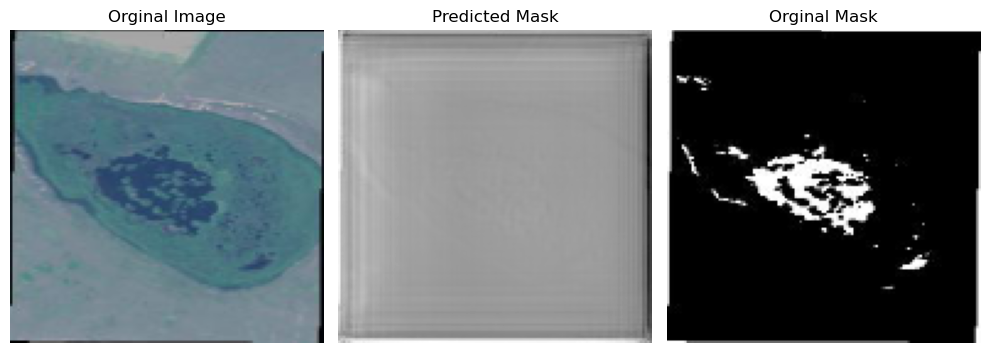

Epoch 2/20
3/3 [==============================] - 15s 4s/step - loss: 0.6693 - accuracy: 0.5678 - IoU: 0.3568 - val_loss: 0.6652 - val_accuracy: 0.5277 - val_IoU: 0.3912


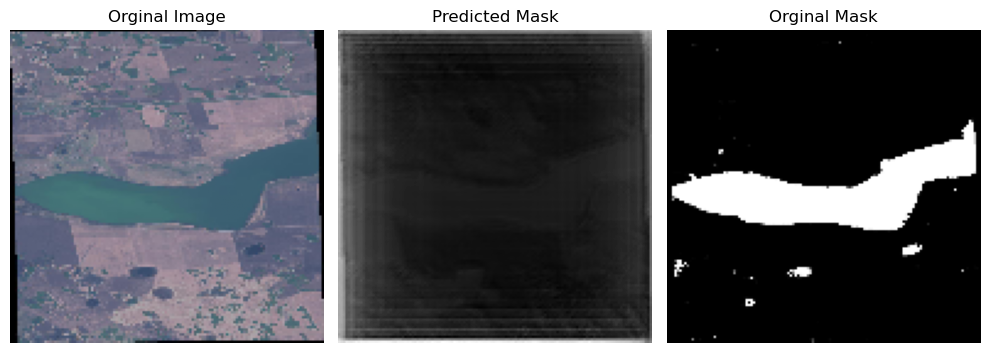

Epoch 3/20
3/3 [==============================] - 14s 5s/step - loss: 0.6231 - accuracy: 0.6057 - IoU: 0.3568 - val_loss: 0.6472 - val_accuracy: 0.5277 - val_IoU: 0.3912


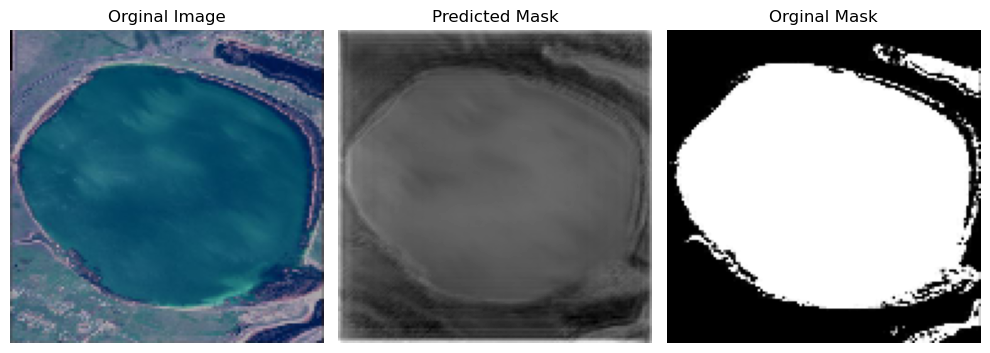

Epoch 4/20
3/3 [==============================] - 15s 4s/step - loss: 0.5583 - accuracy: 0.6210 - IoU: 0.3568 - val_loss: 0.6496 - val_accuracy: 0.5271 - val_IoU: 0.3912


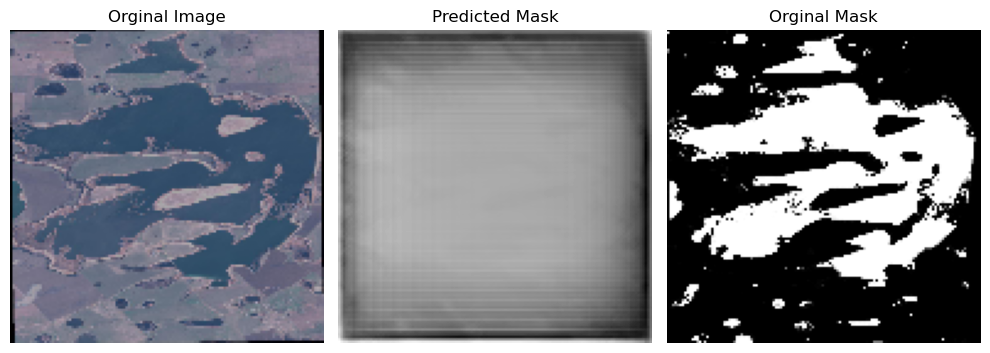

Epoch 5/20
3/3 [==============================] - 15s 4s/step - loss: 0.5839 - accuracy: 0.5603 - IoU: 0.3568 - val_loss: 0.6229 - val_accuracy: 0.5277 - val_IoU: 0.3912


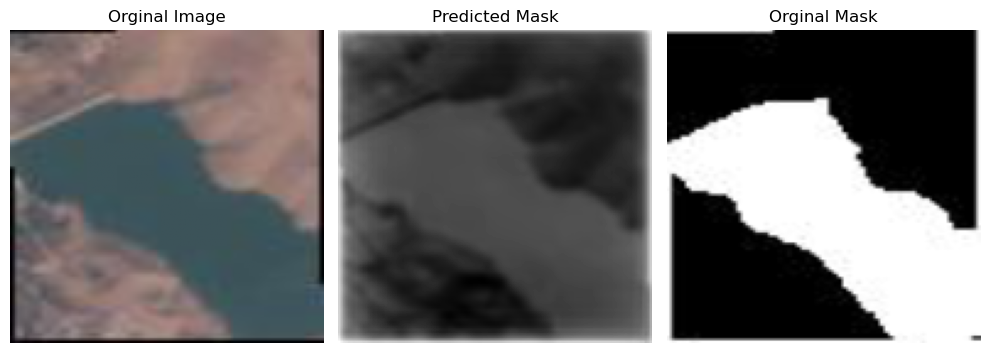

Epoch 6/20
3/3 [==============================] - 15s 5s/step - loss: 0.5112 - accuracy: 0.6378 - IoU: 0.3568 - val_loss: 0.6226 - val_accuracy: 0.5277 - val_IoU: 0.3912


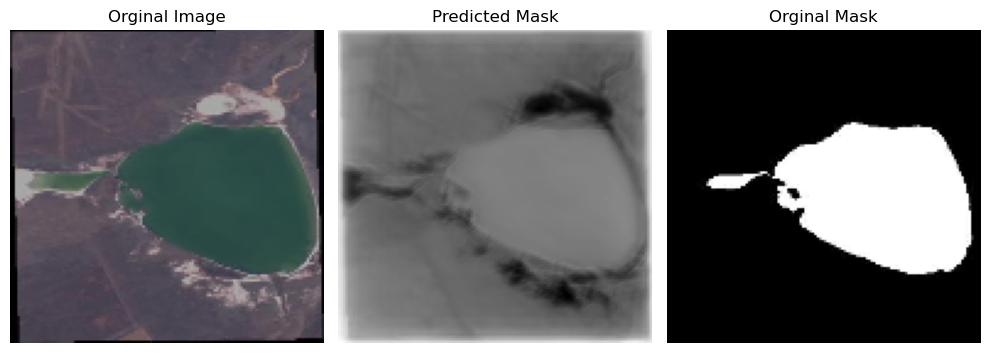

Epoch 7/20
3/3 [==============================] - 15s 5s/step - loss: 0.4912 - accuracy: 0.6498 - IoU: 0.3568 - val_loss: 0.6393 - val_accuracy: 0.5277 - val_IoU: 0.3912


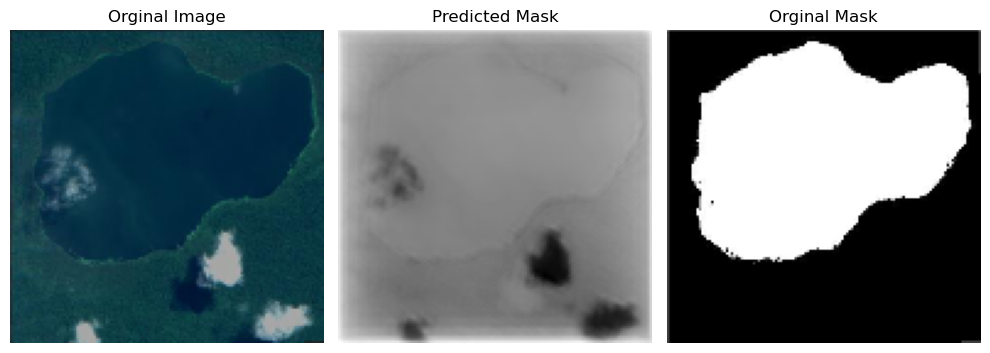

Epoch 8/20
3/3 [==============================] - 15s 4s/step - loss: 0.5664 - accuracy: 0.5970 - IoU: 0.3568 - val_loss: 0.6243 - val_accuracy: 0.5277 - val_IoU: 0.3912


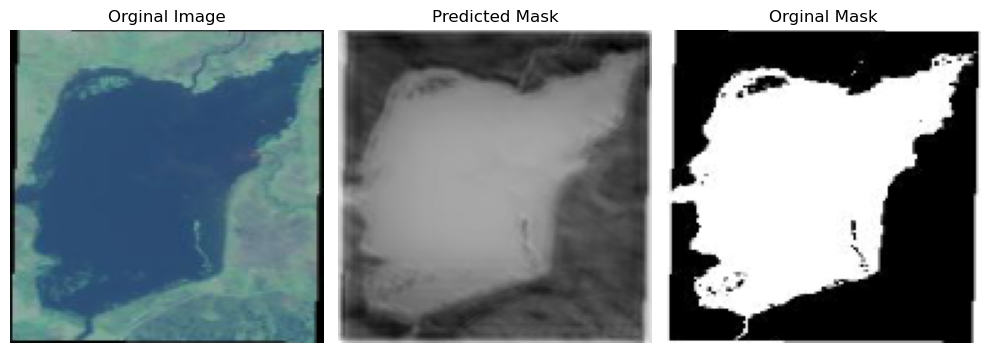

Epoch 9/20
3/3 [==============================] - 14s 4s/step - loss: 0.5057 - accuracy: 0.6350 - IoU: 0.3568 - val_loss: 0.6289 - val_accuracy: 0.5276 - val_IoU: 0.3912


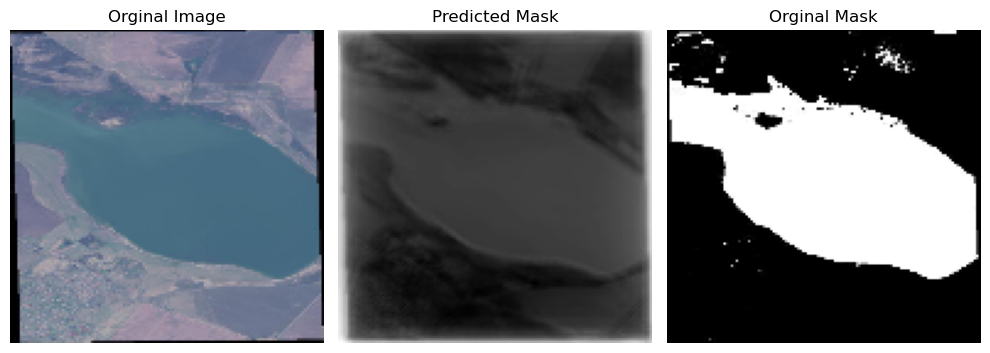

In [17]:
# Model
attention_unet = keras.models.Model(
    inputs=[input_layer],
    outputs=[output_layer],
)

# Compiling
attention_unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("AttentionUNet.h5", save_best_only=True),
    ShowProgress(SIZE=SIZE)
]

# Training
attention_history = attention_unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

Because the **Spatial Information** is shared through the **Skip Connections** and **Attention Model** Initialy pays attention to everything you can see that the Model was able to **keep the Spatial Information** till the **output layer**. This can be a good thing with works like **Lanscape Colorizer**. You can clearly Notice that the **Mask Predictions by Attention UNet are much clear.**

# **Model Comparision**

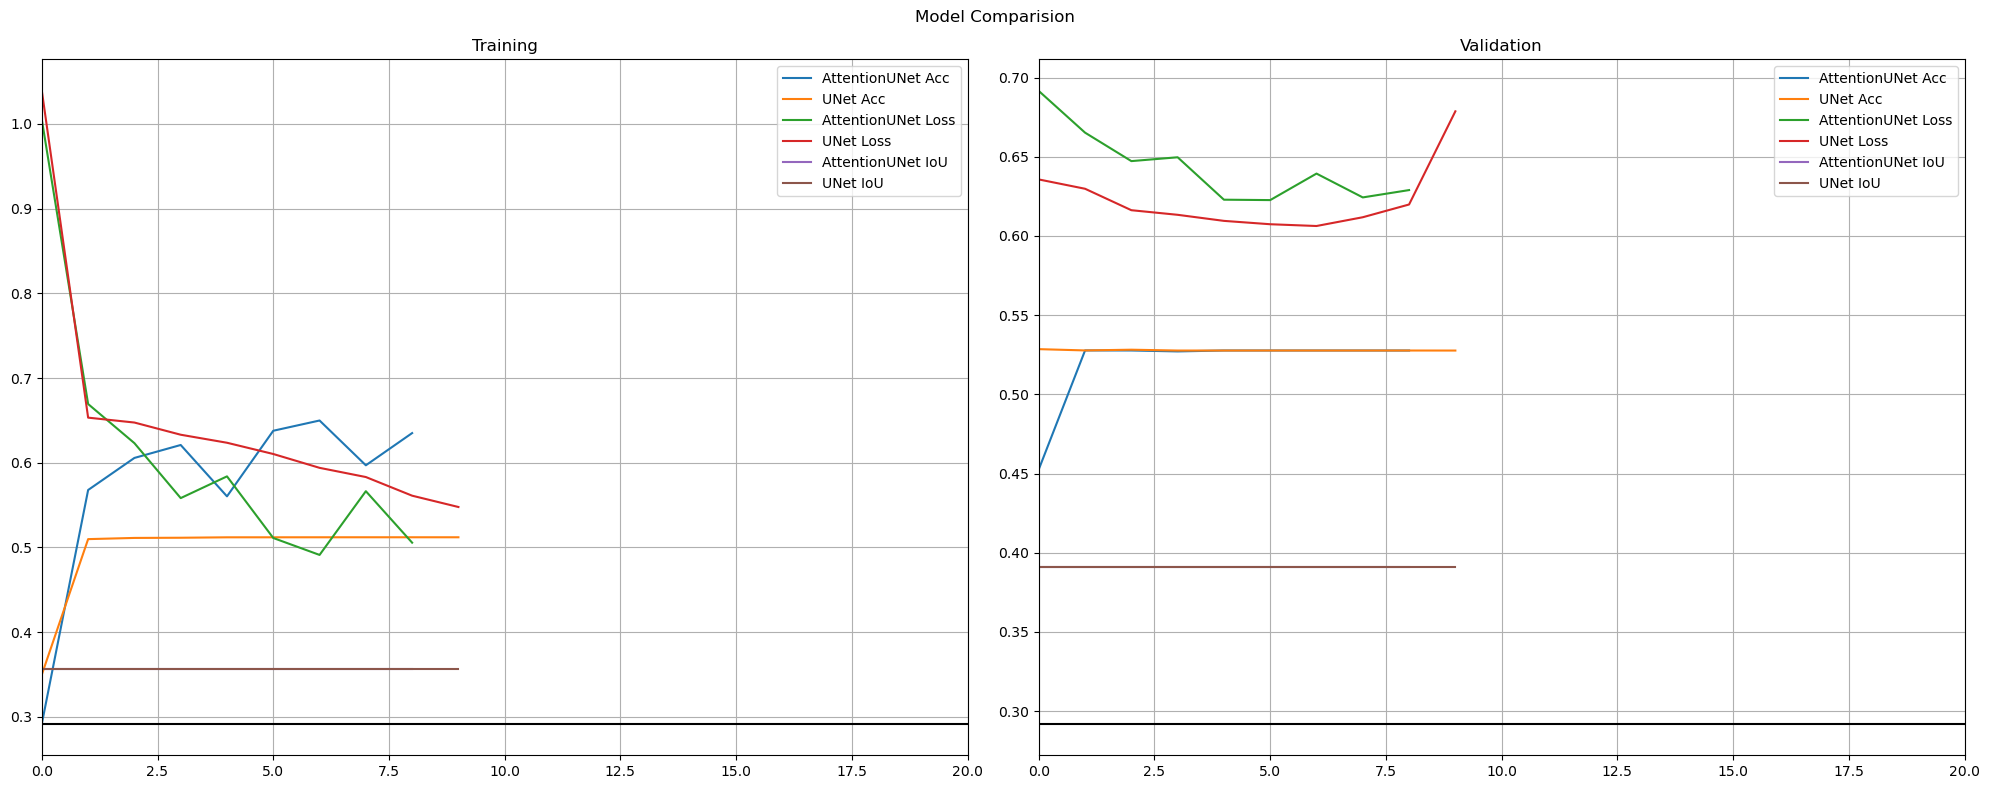

In [19]:
# learning Curves
attention_train_loss, attention_train_acc, attention_train_IoU, attention_valid_loss, attention_valid_acc, attention_valid_IoU  = attention_history.history.values()
unet_train_loss, unet_train_acc, unet_train_IoU, unet_valid_loss, unet_valid_acc, unet_valid_IoU = unet_history.history.values()

# Viz
plt.figure(figsize=(20,8))
plt.suptitle("Model Comparision")

plt.subplot(1,2,1)

plt.title("Training")
plt.plot(attention_train_acc, label="AttentionUNet Acc")
plt.plot(unet_train_acc, label="UNet Acc")

plt.plot(attention_train_loss, label="AttentionUNet Loss")
plt.plot(unet_train_loss, label="UNet Loss")

plt.plot(attention_train_IoU, label="AttentionUNet IoU")
plt.plot(unet_train_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation")
plt.plot(attention_valid_acc, label="AttentionUNet Acc")
plt.plot(unet_valid_acc, label="UNet Acc")

plt.plot(attention_valid_loss, label="AttentionUNet Loss")
plt.plot(unet_valid_loss, label="UNet Loss")

plt.plot(attention_valid_IoU, label="AttentionUNet IoU")
plt.plot(unet_valid_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [22]:
os.listdir()

['notebook.ipynb',
 'notebook-Copy2.ipynb',
 'waterBodiesDataset',
 'UNet.h5',
 '.ipynb_checkpoints',
 'AttentionUNet.h5',
 'model_loading.ipynb']

We can clearly spot the difference, the loss is reduced that means the **Reconstruction has Improved** and in case of **Attention UNet** the **loss is lower** than the **Normal UNet**. Keep in mind that **UNet is best suited for Multi CLass Segmentationa and for Binary Class Segmentation SegNet works great.**

---
Let me know your suggestion, they help me to Improve.
**Thanks !!**

AttributeError: 'Functional' object has no attribute 'save_model'

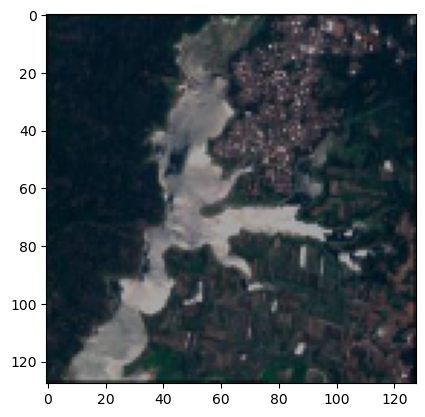

In [42]:
# new_model = tf.keras.models.load_model('./UNet.h5', custom_objects={'EncoderBlock': EncoderBlock})

# Check its architecture
# new_model.summary()

unet_history.save_model(unet_history, 'UNet.h5')

plt.imshow(X[1])
temp = unet.predict(X[:2])
plt.imshow(temp[1])

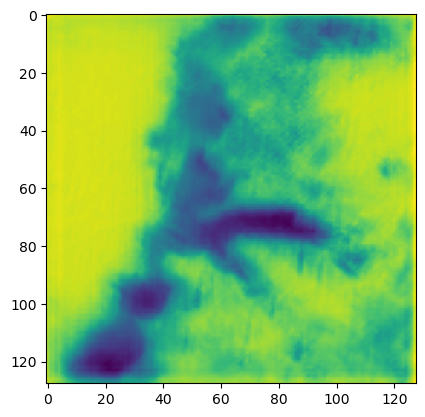

In [52]:
tf.keras.utils.register_keras_serializable()

<function tensorflow.python.keras.utils.generic_utils.register_keras_serializable.<locals>.decorator(arg)>